# An attempt to work out different rooting depths and distributions for savanna sites in Northern Australia
----------

The below technique follows from the SPA version 1 calibration spreadsheet for calculating the root profile of a canopy. My madness on screen as displayed here is to determine whether I can build this in to a parameter estimation workflow in some emulator work saved elsewhere.

In [1]:
# Libraries to import

from scipy.optimize import minimize
from scipy.optimize import leastsq

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# Notebook plot settings

plt.style.use(['fivethirtyeight'])
plt.rcParams['figure.figsize'] = (14, 6)

### Describing the root profile

The distribution of root biomass follows the following conditional equation:

\begin{equation}
r_{mass, z}=
    \begin{cases}
        r_{mass, surf}\left(\frac{-\exp({k\space d_{z+1}})\space+\space\exp({k\space d_{z}})}{k}\right), & \text{if}\ z < z_{root, max} \\\\
        0, & \text{else}
    \end{cases}
\end{equation}

where $z$ is the soil layer, $r_{mass, z}$ is the root biomass (in grams) across some arbitrary depth of soil $d_{z} \rightarrow d_{z+1}$ that describes the volume of the current soil layer, $r_{mass, surf}$ is the density of root biomass at the soil surface, $k$ is the decline coefficient, and $z_{root, max}$ is the maximum rooting depth in terms of soil layer.

The density of roots for each layer is then determined as:

\begin{equation}
    r_{dens, z} = \frac{r_{mass, z}}{z_{thick}}
\end{equation}

And finally the fraction of roots at some aribtrary depth $z$ is determed as:

\begin{equation}
    r_{frac, z} = \frac{r_{dens, z}}{r_{mass, total}}
\end{equation}


The decline coefficient seems to be site-specific and this is pre-determined via optimising on it ala:

\begin{equation}
    \chi_{\min}^{2} = \min\left( r_{mass, total} - \sum_{z=0}^{N} r_{mass, z}\right)
\end{equation}

We can now use these equations to come up with a set of shallow-to-deep root profiles based on collected site information.

### Example case: Howard Springs

Very little information has been collected on root distributions along the NATT, with the only noteable cases being Howard Springs (see Chen et al. 2002; and Kelley et al. 2007) - could be wrong though. Prior information to work with is therefore limited but can be used to get a ballpark idea of the root profile:

$r_{mass, total} = 1930 \space g\space m^{-2}$

Pretty much everything else is determined by tweaking the model. From previous work the following root profile information has been used.

$r_{mass, surf} = 14000 \space g\space m^{-3}$

$z_{root, max} = 6.0 \space m$


Soil texture information is extracted from the Australian Digital Soil Atlas, and for this site A/B horizon for the soil profile is:

**Horizon A:** 55 % sand | 5 % clay

**Horizon B:** 45 % sand | 10 % clay

In [10]:
# default number of soil layers
nlayer = 20

# create 20 soil layers
soil_layer = ["layer_{0}".format(i+1) for i in (range(nlayer))] + ['core']

# set the thicknesses of the 20 soil layers, divide accordingly to match with common field measurements
soil_thick = [0.1 if z < 4 else 0.2 if (z >= 4) & (z < 12) \
                else 0.1 if (z == len(soil_layer) - 1) else 1.0 \
                  for (z, _) in enumerate(soil_layer)]

soil_depth = np.cumsum([0] + soil_thick)

# create a dataframe to work with
soil_df = pd.DataFrame({'thick': soil_thick, 'depth': soil_depth[:-1], 'layer': soil_layer})
soil_df.set_index(['layer'], inplace=True)

print(soil_df)

          depth  thick
layer                 
layer_1     0.0    0.1
layer_2     0.1    0.1
layer_3     0.2    0.1
layer_4     0.3    0.1
layer_5     0.4    0.2
layer_6     0.6    0.2
layer_7     0.8    0.2
layer_8     1.0    0.2
layer_9     1.2    0.2
layer_10    1.4    0.2
layer_11    1.6    0.2
layer_12    1.8    0.2
layer_13    2.0    1.0
layer_14    3.0    1.0
layer_15    4.0    1.0
layer_16    5.0    1.0
layer_17    6.0    1.0
layer_18    7.0    1.0
layer_19    8.0    1.0
layer_20    9.0    1.0
core       10.0    0.1


Now create a function to determine the root biomass per soil layer

In [4]:
def root_biom(rz_a, rz_b, kd, rdsurf):
    """
    rz_a = root layer at depth z + 1
    rz_b = root layer at depth z
    kd = decay coefficient
    rdsurf = root density at the surface
    """
    return rdsurf*(-np.exp(-kd*rz_a)/kd + np.exp(-kd*rz_b)/kd)

We now want to create the *cost-function* to determine our extinction coefficient and therefore the distribution of roots through the profile. We're using the scipy's optimise package as it is really fast.

In [5]:
def root_biom_vx(kd, rd_surf, x_depth, zmax):
    rbm = [root_biom(x_depth[i + 1], x_depth[i], kd, rd_surf) \
            if i < zmax else 0.0 \
            for i in range(len(x_depth))]
    return rbm

def get_root_dist(rb_total, rd_surf, x_depth, zmax):
   
    cost_fun2 = lambda kd: abs(rb_total - sum(root_biom_vx(kd, rd_surf, x_depth, zmax)))

    # now find the coefficient
    res = leastsq(cost_fun2, x0=3)
    # optimal parameter
    kd_0 = res[0][0]
    
    # now we can determine the root density per soil layer
    root_biom = root_biom_vx(kd_0, rd_surf, x_depth, zmax)
    # return to user
    return (root_biom, kd_0)

Test that the above minimiser functions works accordingly... and it (collectively) seems to do just fine. So lets test a bunch of profile and visualise what they might look like.

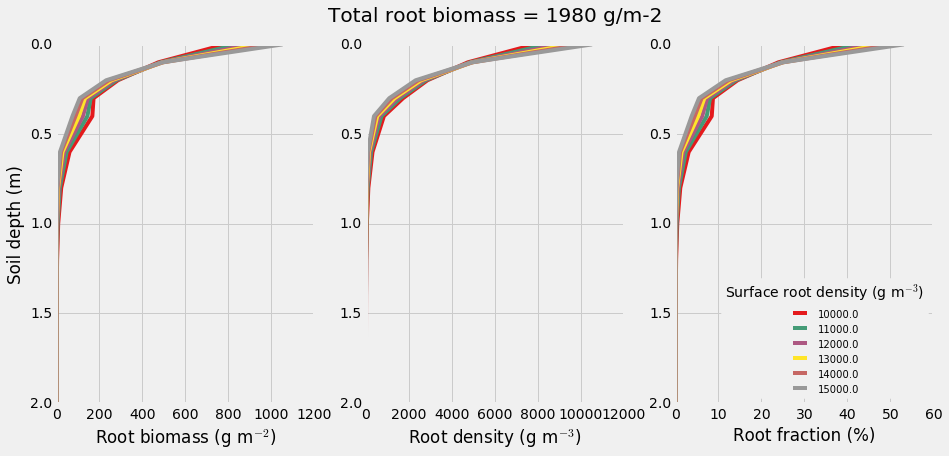

In [18]:
rd_surf = 1.4e4
rb_total = 1980
root_depth = 17

# test
rdens_list = np.linspace(1e4, 15e3, 6)
color_list = plt.get_cmap('Set1', len(rdens_list))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132, sharey=ax1)
ax3 = plt.subplot(133, sharey=ax1)

for (i, rd) in enumerate(rdens_list):

    rbm, _ = get_root_dist(rb_total, rd, soil_depth[:-1], root_depth)
    rdn = np.array(rbm)/np.array(soil_thick)
    rfr = np.array(rbm)/rb_total*100
    
    ax1.plot(rbm, soil_depth[:-1], label=rd, color=color_list(i))
    
    ax2.plot(rdn, soil_depth[:-1], label=rd, color=color_list(i))
    
    ax3.plot(rfr, soil_depth[:-1], label=rd, color=color_list(i))


ax1.set_ylim([0, 2])
ax1.set_ylabel(r'Soil depth (m)')

ax1.set_xlabel(r'Root biomass (g m$^{-2}$)')
ax2.set_xlabel(r'Root density (g m$^{-3}$)')
ax3.set_xlabel(r'Root fraction (%)')

ax2.set_title('Total root biomass = {0} g/m-2'.format(rb_total), y=1.05)

ax1.invert_yaxis()

ax3.legend(loc='lower right', title="Surface root density (g m$^{-3}$)", fontsize=10)

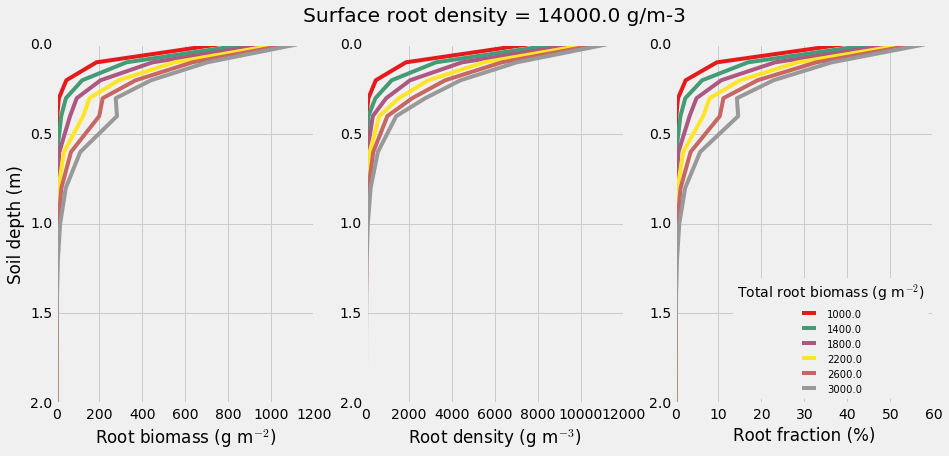

In [78]:
rd_surf = 1.4e4
rb_total = 1930
root_depth = 17

# test
rbtot_list = np.linspace(1e3, 3e3, 6)
color_list = plt.get_cmap('Set1', len(rdens_list))

ax1 = plt.subplot(131)
ax2 = plt.subplot(132, sharey=ax1)
ax3 = plt.subplot(133, sharey=ax1)

for (i, rb) in enumerate(rbtot_list):

    rbm, _ = get_root_dist(rb, rd_surf, soil_depth[:-1], root_depth)
    rdn = np.array(rbm)/np.array(soil_thick)
    rfr = np.array(rbm)/rb_total*100
    
    ax1.plot(rbm, soil_depth[:-1], label=rb, color=color_list(i))
    ax2.plot(rdn, soil_depth[:-1], label=rb, color=color_list(i))
    ax3.plot(rfr, soil_depth[:-1], label=rb, color=color_list(i))

ax1.set_ylim([0, 2])
ax1.set_ylabel(r'Soil depth (m)')

ax1.set_xlabel(r'Root biomass (g m$^{-2}$)')
ax2.set_xlabel(r'Root density (g m$^{-3}$)')
ax3.set_xlabel(r'Root fraction (%)')

ax2.set_title('Surface root density = {0} g/m-3'.format(rd_surf), y=1.05)

ax1.invert_yaxis()

ax3.legend(loc='lower right', title="Total root biomass (g m$^{-2}$)", fontsize=10)

### Alternative using Jackson et al. (1996), Oecologia 108: pp389-411

This is another highly cited way of determining the fraction of root biomass per soil depth; based on a global analysis of root distributions for different biomes. Data for various ecosystems or plant functional types (PFTs) were used to fit a simple decay function, with the decay coefficient determined for each PFT, as follows:

\begin{equation}
    Y = 1 - \beta^{d}
\end{equation}

where $Y$ is the root fraction at depth, $d$, and $\beta$ is the decay coefficient that has a range of approximately 0.90 to 0.98.

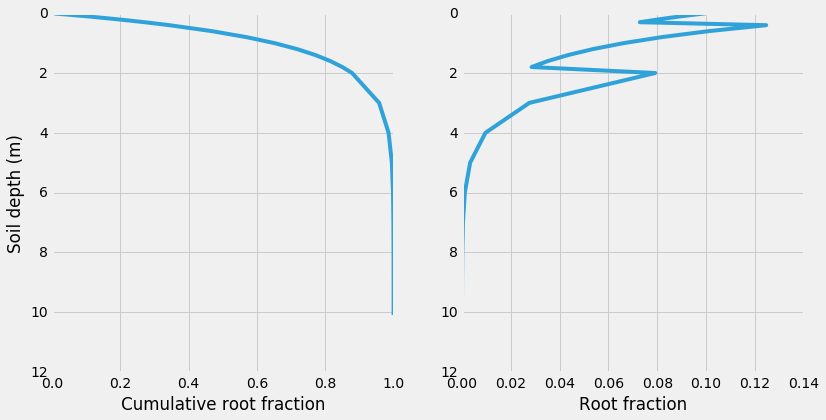

In [66]:
jackson = lambda B, d: 1 - B**(d*10)
cum_rfrac = [jackson(0.9, d) for d in soil_depth]

plt.figure(figsize=(12, 6))
ax1 = plt.subplot(121)
ax1.plot(cum_rfrac, soil_depth, '-', label='cumulative root frac')
ax1.invert_yaxis()

ax2 = plt.subplot(122, sharey=ax1)
rfrac = [cum_rfrac[i+1] - cum_rfrac[i] for i in range(len(cum_rfrac)-1)]
ax2.plot(test, soil_depth[:-1], '-', label='root frac')

ax1.set_ylabel('Soil depth (m)')
ax1.set_xlabel('Cumulative root fraction')
ax2.set_xlabel('Root fraction')
